#Preparation

In [ ]:
# Allow Collab to connect to your Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the data on Drive
root = "/content/drive/MyDrive/PhD/Integrated_Gradient"


Mounted at /content/drive


In [ ]:
!pip install torchsummary

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import os, time, math, copy
import numpy as np
from scipy.stats import spearmanr


In [ ]:
# Checking if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
print("Found:",torch.cuda.device_count(), device)


Found: 0 cpu


In [ ]:
# Load the test MNIST dataset
def get_mnist_dataloaders(val_percentage = 0.1, batch_size = 1, shuffle = False):
    dataset_test = datasets.MNIST(f"{root}/dataset", train=False,  download=True, transform=transforms.ToTensor())
    data_loader_test  = DataLoader(dataset_test,  batch_size = batch_size, shuffle = shuffle, num_workers = 2)

    return data_loader_test, len(dataset_test)


In [ ]:
class CNN(nn.Module):
    """Small sized network """    
    def __init__(self, name, map = 5, stride = 1):
        self.name = name
        fc_output_size  = 50
        map_size        = map   #(3,5,7,9,11,...)
        block1_features = 25
        block2_features = 50
        stride          = stride
        
        super().__init__()

        # Activation function
        if self.name.split("_")[0] == "smooth":
            self.a = torch.nn.Softplus()
        else: 
            self.a = torch.nn.ReLU()

        # Conv block 1
        self.conv1 = nn.Conv2d(1, block1_features, map_size, padding = 1, stride = stride)
        fc_input_size = np.floor((28 - map_size +2 * 1) / stride + 1)     

        # Max pooling
        fc_input_size /= 2
        
        # Conv block 2
        self.conv3 = nn.Conv2d(block1_features, block2_features, map_size, padding = 1, stride = stride)
        fc_input_size = np.floor((-map_size + 2 * 1 + fc_input_size) / stride + 1)  

        # Max pooling
        fc_input_size /= 2
        
        # Fully connected layers
        self.fc1 = nn.Linear(block2_features * int(fc_input_size) ** 2, fc_output_size)
        self.fc2 = nn.Linear(fc_output_size, 10)        

    def forward(self, x):
        x = self.a(self.conv1(x))
        x = F.max_pool2d(x, 2)    
        x = self.a(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)       
        x = self.a(self.fc1(x))
        x = self.fc2(x)

        return x
        

In [ ]:
# Load trained model
model = CNN("smooth_CNN_mixup").to(device)
model.load_state_dict(torch.load(f"{root}/models/{model.name}.pt", map_location=torch.device(device)))
model.eval()


NameError: ignored

# Vanilla Gradient

In [ ]:
def vanilla_saliency(input, target, model):
    input.requires_grad = True
    output = model(input)

    with torch.no_grad():
        probs = F.softmax(output, dim = -1)
        pred = torch.argmax(output).item()

    # Right class was predicted, return one gradient
    if (pred == target):
        output[0, pred].backward()
        grad_1 = input.grad.clone().detach()
        grad_2 = []
    # Wrong class, return saliencies of both predicted and true class
    else:
        output[0, pred].backward(retain_graph = True)
        grad_1 = input.grad.clone().detach()

        # Reset gradients
        model.zero_grad()
        input.grad.zero_()

        output[0, target].backward()
        grad_2 = input.grad.clone().detach()
    
    model.zero_grad()
    input.grad.zero_()
    input.requires_grad = False
    return pred, probs, grad_1, grad_2


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


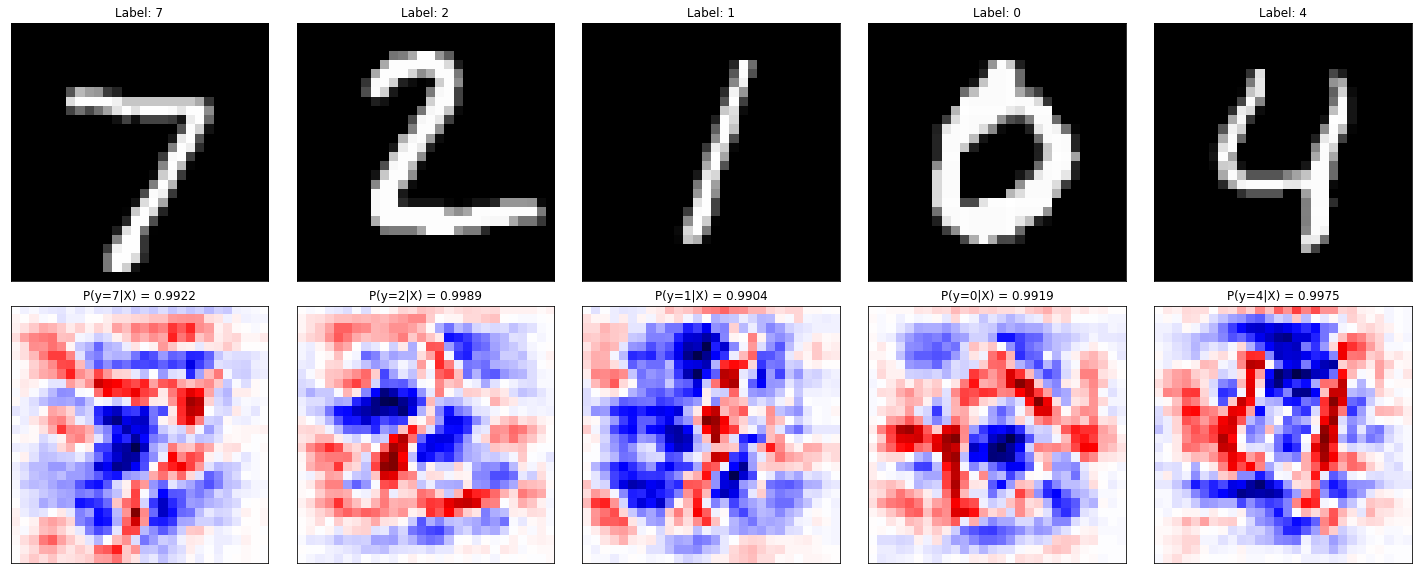

In [ ]:
def plot_saliencies(model):
    test_data_loader, _= get_mnist_dataloaders(shuffle = False)
    num_row = 2
    num_col = 5 # plot 5 different digits images
    num_images = num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(4 * num_col,4 * num_row))

    for i, (x,y) in enumerate(test_data_loader):
        if i >= num_col:
            break
        # Plot digit
        ax = axes[0, i]
        ax.imshow(x.numpy().squeeze().reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {y.item()}")
        ax.set_xticks([])
        ax.set_yticks([])

        x = x.to(device=device)
        x = 2 * x - 1
        y = y.to(device=device)

        # Plot saliency and prediction
        ax = axes[1, i]
        pred, prob, grad, _ = vanilla_saliency(x, y, model)
        ax.imshow(grad.numpy().squeeze(), cmap = 'seismic', norm = TwoSlopeNorm(0))
        ax.set_title(f"P(y={pred}|X) = {prob[0, pred]:.4f}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    #plt.savefig(f"{root}/results/Gradient/{model.name}_right_pred_gradient.pdf", bbox_inches='tight')
    plt.show()
    
plot_saliencies(model)


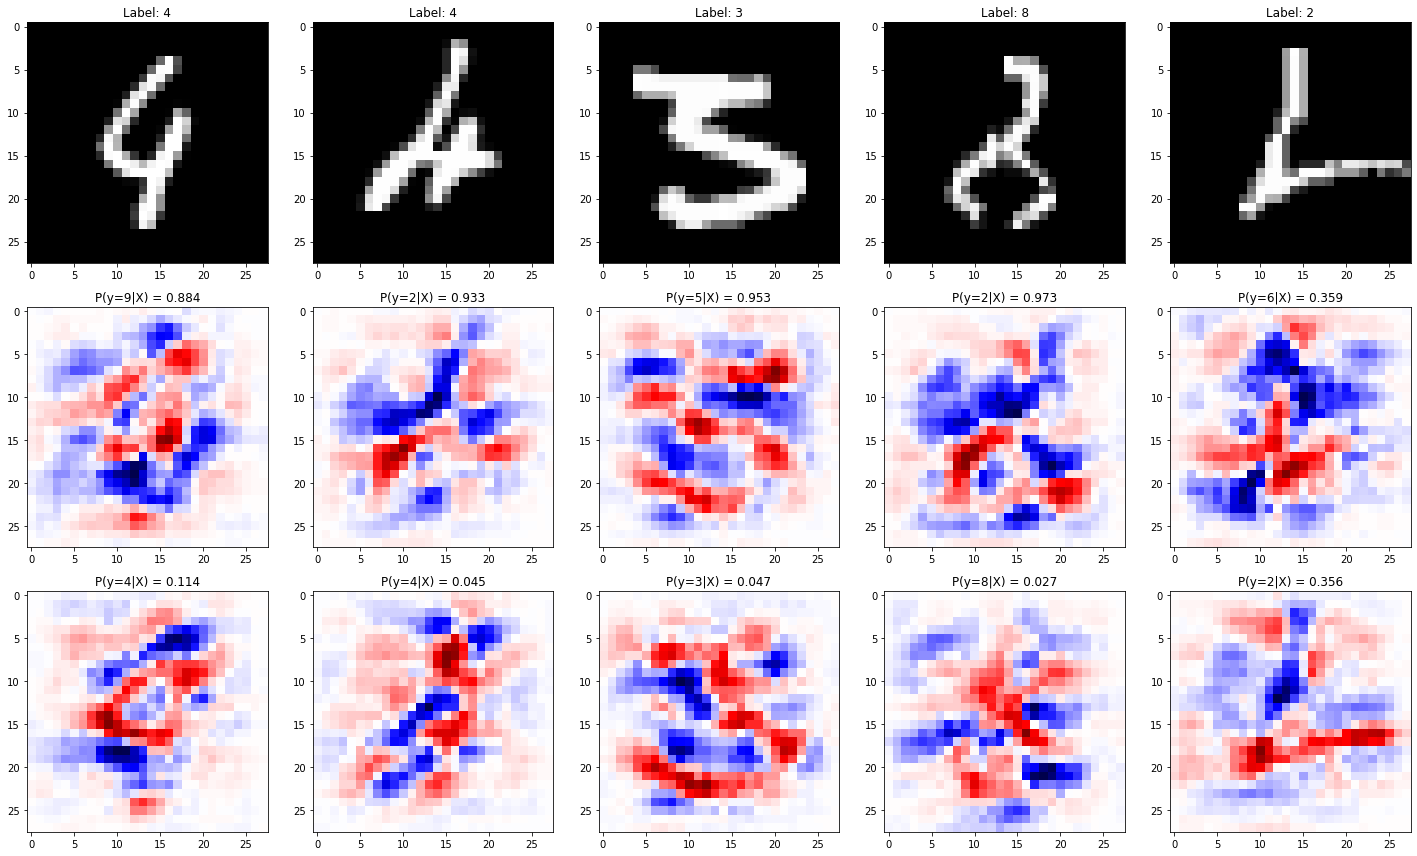

In [ ]:
def plot_errors_saliencies(model):
    test_data_loader, _= get_mnist_dataloaders()
    num_row = 3
    num_col = 5 # plot 5 different digits images
    num_images = num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(4 * num_col,4 * num_row))

    num_errors = 0

    for i, (x, y) in enumerate(test_data_loader):

        x = x.to(device=device)
        x = 2 * x - 1
        y = y.to(device=device)

        pred, prob, grad_1, grad_2 = vanilla_saliency(x, y, model)

        if not pred == y:
            # Plot images with errors
            ax = axes[0, num_errors]
            ax.imshow(x.numpy().squeeze(), cmap='gray')
            ax.set_title(f"Label: {y.item()}")

            # Plot saliency of prediction
            ax = axes[1, num_errors]
            ax.imshow(grad_1.detach().numpy().squeeze(), cmap = 'seismic', norm = TwoSlopeNorm(0))
            ax.set_title(f"P(y={pred}|X) = {prob[0, pred]:.3f}")

            # Plot saliency of prediction
            ax = axes[2, num_errors]
            ax.imshow(grad_2.detach().numpy().squeeze(), cmap = 'seismic', norm = TwoSlopeNorm(0))
            ax.set_title(f"P(y={y.item()}|X) = {prob[0, y.item()]:.3f}")

            num_errors += 1

        if num_errors == num_col:
            break


    plt.tight_layout()
    #plt.savefig(f"{root}/results/Gradient/{model.name}_wrong_pred_gradient.pdf", bbox_inches='tight')
    plt.show()
    
plot_errors_saliencies(model)

# IG

In [ ]:
def IG_interp_saliency(input, baseline, model, n_steps = 200):

    output = model(input)

    with torch.no_grad():
        probs = F.softmax(output, dim = -1)
        pred = torch.argmax(output).item()

    # Create linear path
    alpha = torch.linspace(0, 1, n_steps)
    dalpha = 1 / (n_steps - 1)
    x = torch.cat([ a * input + (1 - a) * baseline for a in alpha])
    #print(x.shape)

    # Forward pass
    x.requires_grad = True
    model.zero_grad()
    output = model(x)
    probs = F.softmax(output, dim = -1)

    # Compute Integrated Gradient
    A = torch.ones((1, n_steps)) * dalpha
    A[0, 0] *= 0.5
    A[0, -1] *= 0.5
    A_p = torch.matmul(A, probs[:, [pred]])
    A_p.backward()
    partial_attrib = x.grad * (input - baseline)

    model.zero_grad()
    return pred, probs.detach(), x.detach(), partial_attrib
    

### Implementation

In [ ]:
# Load SPECIFIC instances
dataset_test = datasets.MNIST(f"{root}/dataset", train=False,  download=True, transform=transforms.ToTensor())
# 0 4
# 1 5
# 2 6
i = 0  # 0, 1 or 2
x, y = dataset_test[i]
x_baseline, y_baseline = dataset_test[i + 4]
x = 2 * x - 1
x_baseline = 2 * x_baseline - 1
x = x.unsqueeze(0)
x_baseline = x_baseline.unsqueeze(0)

pred, probs, path, partial_attribution = IG_interp_saliency(x, x_baseline, model)
print(probs[-1, pred] - probs[0, pred])
partial_attribution.sum()


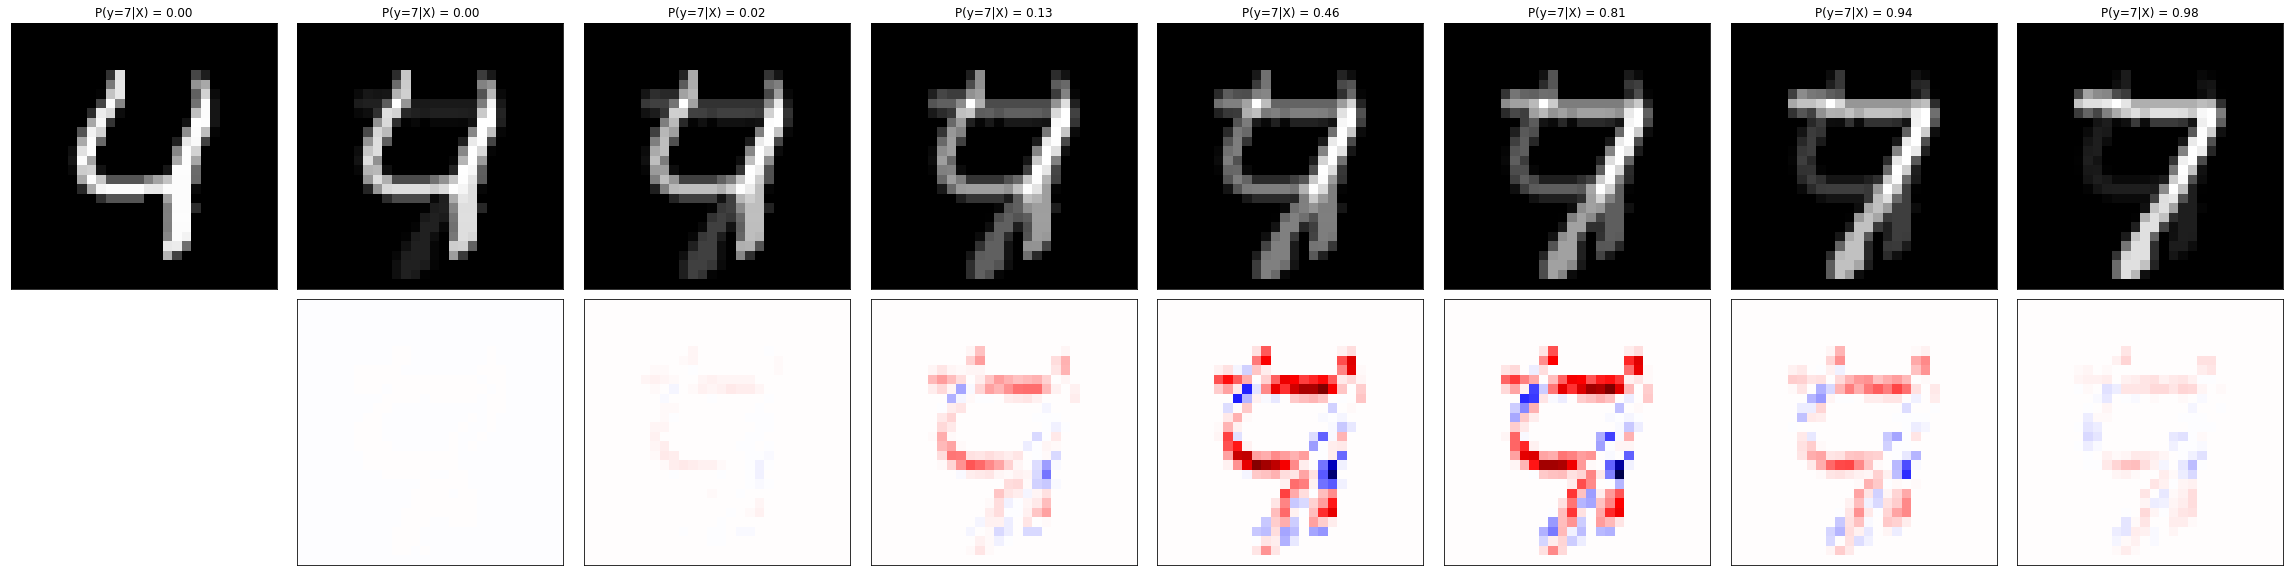

In [ ]:
num_row = 2
num_col = 8
num_images = num_row * num_col

# All partial contributions
fig, axes = plt.subplots(num_row, num_col, figsize=(4 * num_col,4 * num_row))
step = int(200 / num_col)

# Compute the partial attribution on each step
step_attribution = partial_attribution[1:(num_col - 1) * step + 1, :].view(num_col - 1, step, 28, 28).sum(dim = 1)

min = step_attribution.min()
max = step_attribution.max()

for i in range(num_col):
    # Plot digit
    ax = axes[0, i]
    ax.imshow(path[i * step, :].numpy().squeeze().reshape(28, 28), cmap='gray')
    ax.set_title(f"P(y={pred}|X) = {probs[i * step, pred]:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot attribution
    if not i == 0:
        ax = axes[1, i]
        ax.imshow(step_attribution[i - 1, :].numpy(), cmap = 'seismic', norm = TwoSlopeNorm(0, min, max))
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        axes[1, i].axis('off')

plt.tight_layout()
#plt.savefig(f"{root}/results/IG/{model.name}_{y_baseline}_to_{y}_linear.pdf", bbox_inches='tight')
plt.show()


([], <a list of 0 Text major ticklabel objects>)

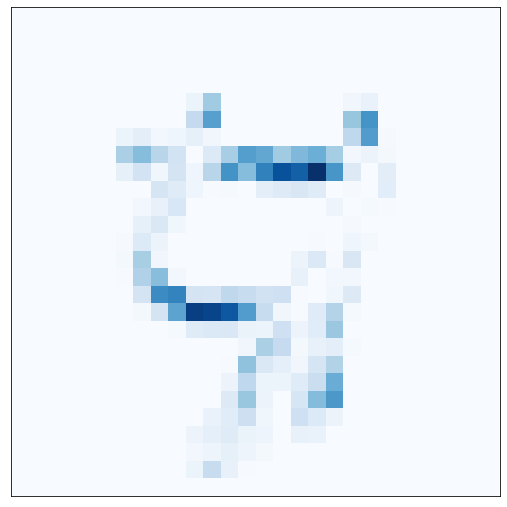

In [ ]:
# IG feature importance

plt.figure(figsize = (9, 9))
plt.imshow(torch.abs(partial_attribution).sum(dim = 0).squeeze(), cmap = 'Blues')
plt.xticks([])
plt.yticks([])


### Sanity Checks

In [ ]:
# Convergence of quadrature O(n^2)
# We must have that sum_i phi_i = f(x) - f(baseline)

step_space = np.logspace(1, 3, 20)
errors = []
for n_step in step_space:
    pred, probs, _, partial_attrib = IG_interp_saliency(x, x_baseline, model, n_steps=int(n_step))
    errors.append(torch.abs((probs[-1, pred] - probs[0, pred]) - partial_attrib.sum()))


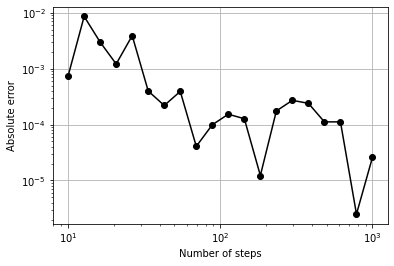

In [ ]:
# Convergence log-log plot
plt.plot(step_space, errors, "k-o")
plt.xlabel("Number of steps")
plt.ylabel("Absolute error")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)


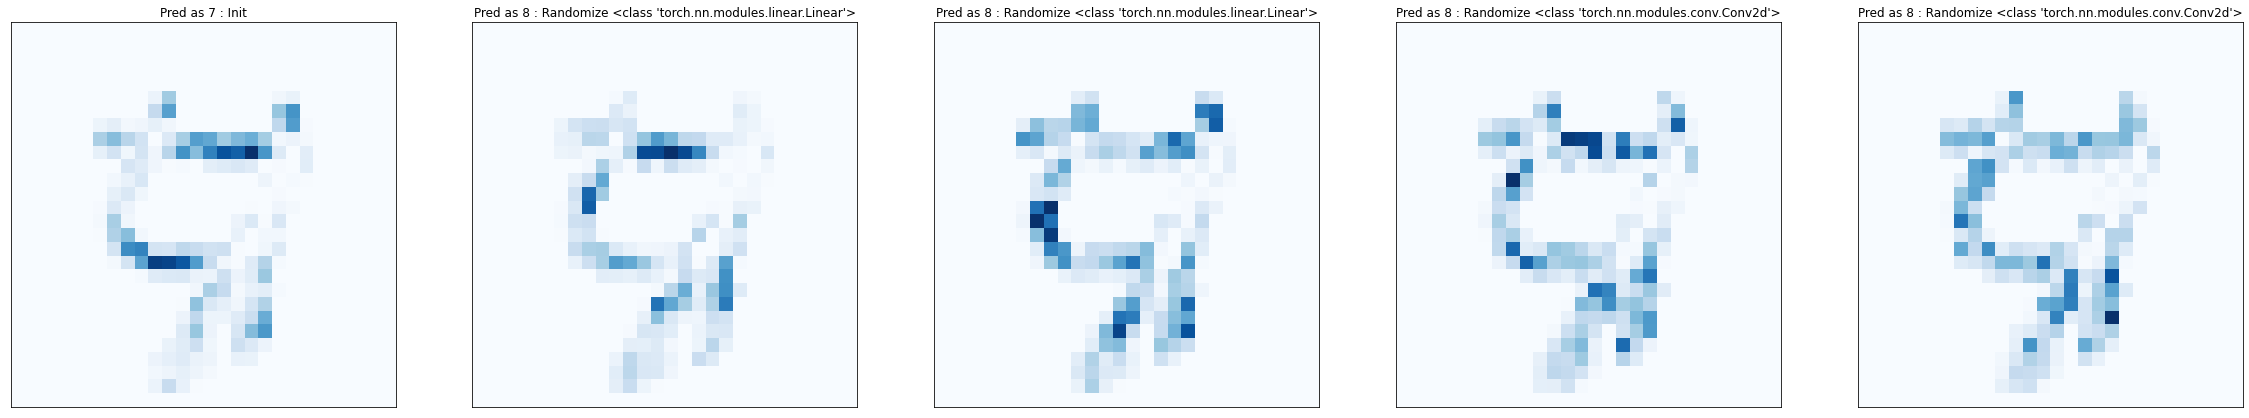

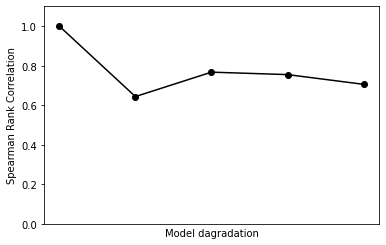

In [ ]:
# Abedayo et al. Sanity check of gradually perturbing the model.
def cascade_perturbation():

    fig, axes = plt.subplots(1, 5, figsize = (40, 60))

    non_null_idx = torch.where((x.ravel() > -1) | ( x_baseline.ravel() > -1))[0].numpy()
    spearman_rank = [1]

    # IG feature importance
    pred, _, _, partial_attribution = IG_interp_saliency(x, x_baseline, model)
    IG_init = torch.abs(partial_attribution).sum(dim = 0).squeeze().numpy()
    axes[0].imshow(IG_init, cmap = 'Blues')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title(f"Pred as {pred} : Init")

    index = 1

    # Cascade
    for layer in reversed(list(model.children())):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.reset_parameters()

            pred, _, _, partial_attribution = IG_interp_saliency(x, x_baseline, model)
            IG = torch.abs(partial_attribution).sum(dim = 0).squeeze().numpy()\
            
            spearman_rank.append(spearmanr(IG_init.ravel()[non_null_idx], IG.ravel()[non_null_idx])[0])

            axes[index].imshow(IG, cmap = 'Blues')
            axes[index].set_xticks([])
            axes[index].set_yticks([])
            axes[index].set_title(f"Pred as {pred} : Randomize {type(layer)}")
            index += 1

    model.load_state_dict(torch.load(f"{root}/models/{model.name}.pt", map_location=torch.device(device)))

    # Spearman rank degradation
    plt.figure()
    plt.plot(spearman_rank, "k-o")
    plt.xlabel("Model dagradation")
    plt.ylabel("Spearman Rank Correlation")
    plt.xticks([])
    plt.ylim([0, 1.1])
    plt.show()

cascade_perturbation()

# AIG

In [ ]:
# Class specific MNIST
class Class_MNIST(torch.utils.data.Dataset):
    def __init__(self, baseline_class, MNIST):
        super(torch.utils.data.Dataset, self).__init__()
        self.parent = MNIST
        self.idx = torch.where(MNIST.targets == baseline_class)[0]
        
    def __len__(self):
         return len(self.idx)
        
    def __getitem__(self, index):
        return self.parent[self.idx[index]]


In [ ]:
# Load SPECIFIC instances 7
dataset_test = datasets.MNIST(f"{root}/dataset", train=False,  download=True, transform=transforms.ToTensor())
i = 0  # 0, 1 or 2
x, y = dataset_test[i]
x = 2 * x - 1
x = x.unsqueeze(0)


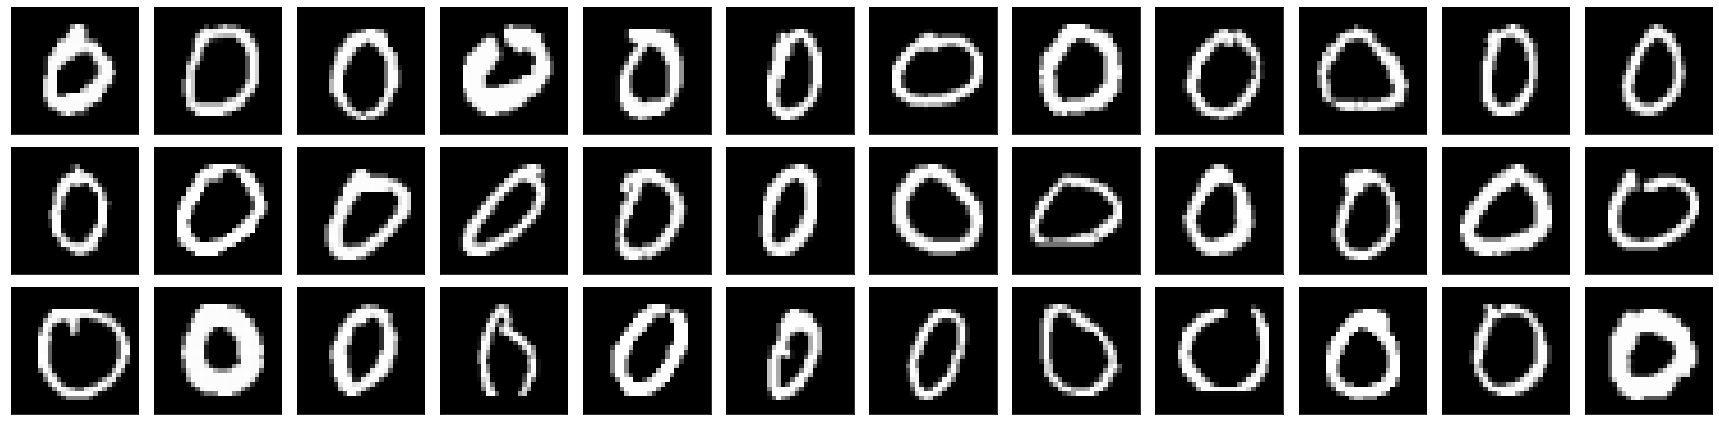

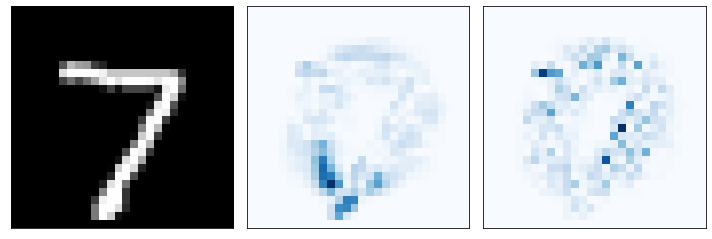

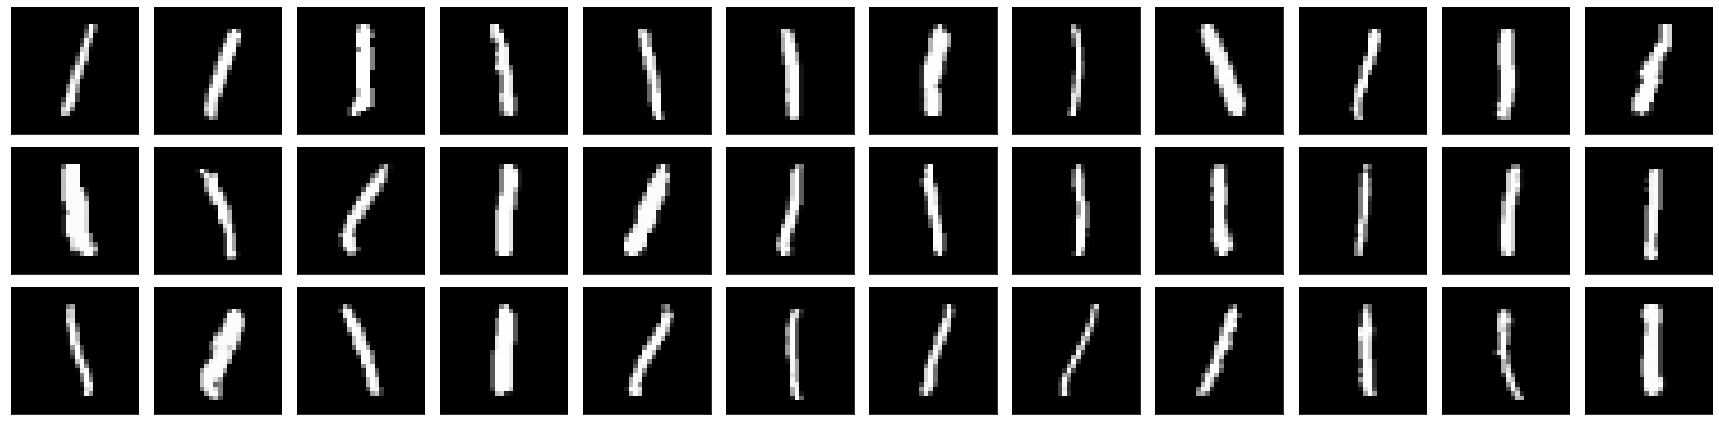

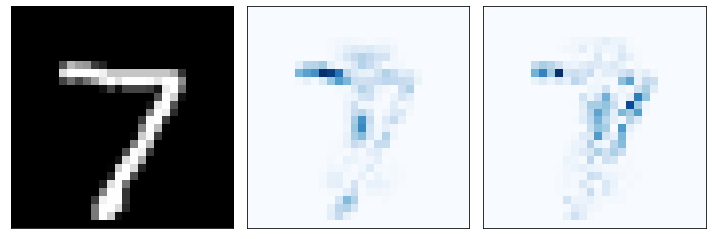

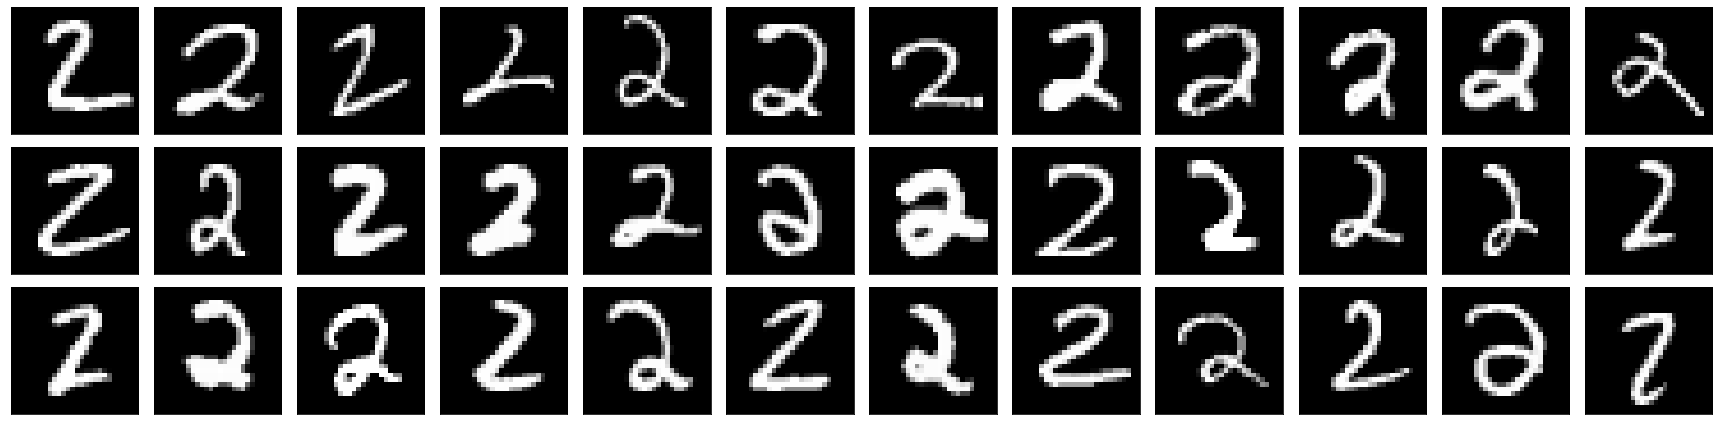

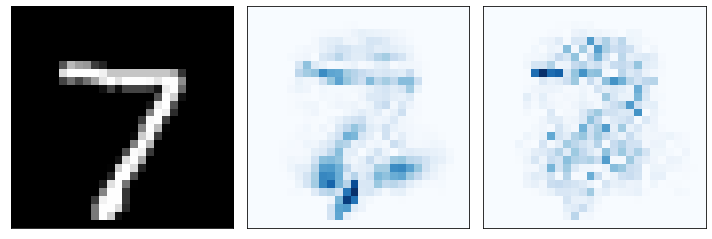

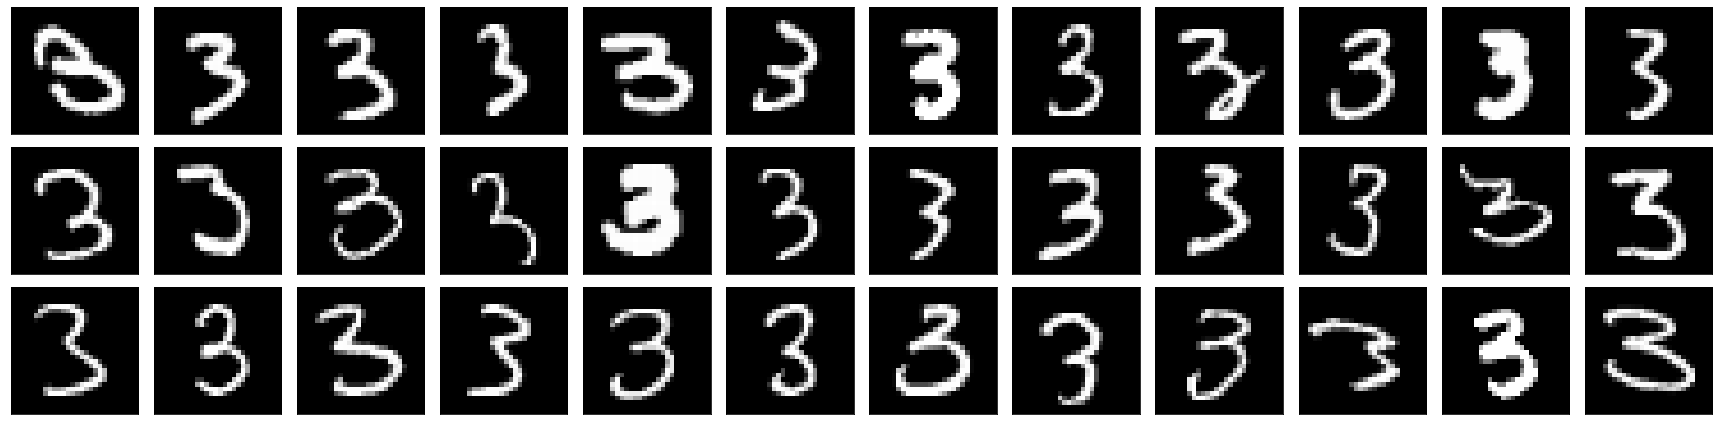

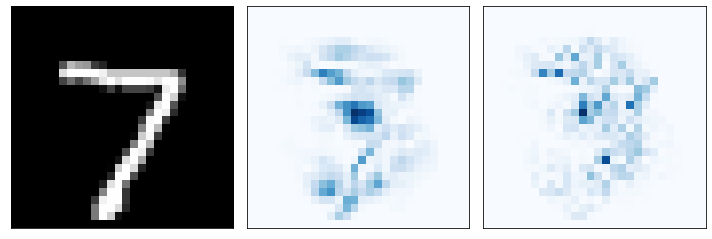

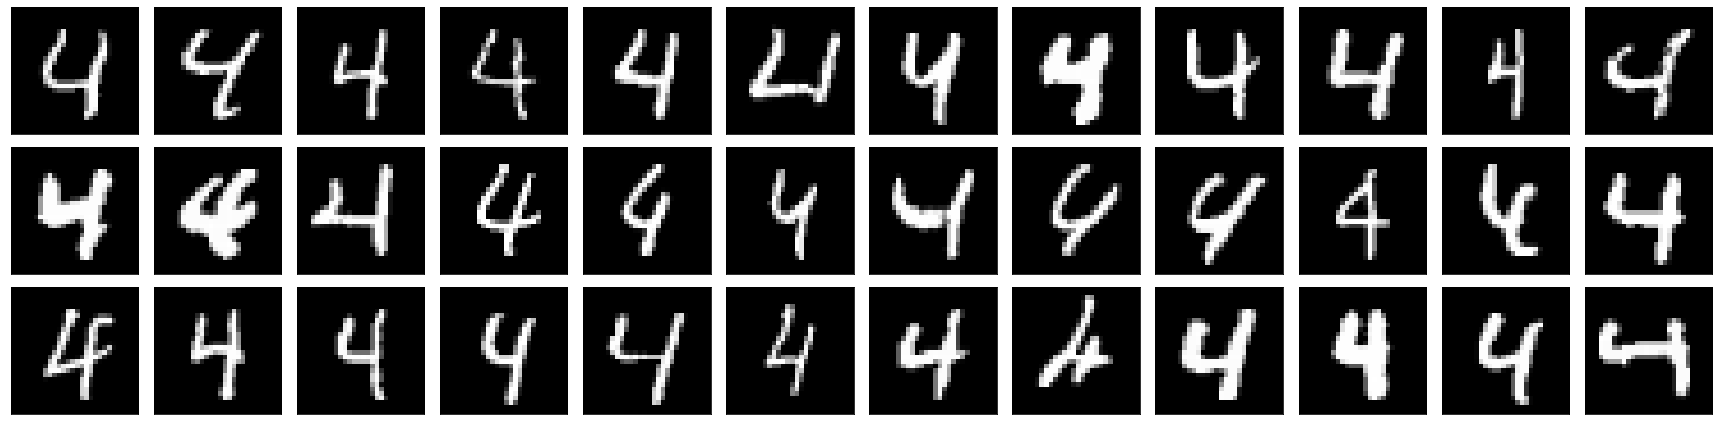

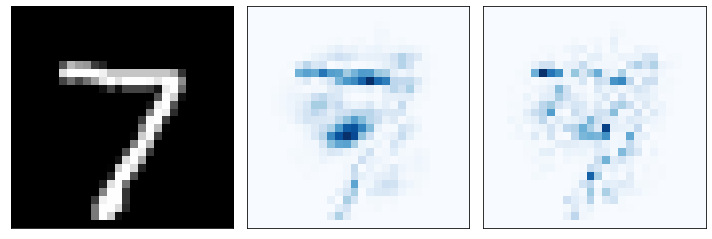

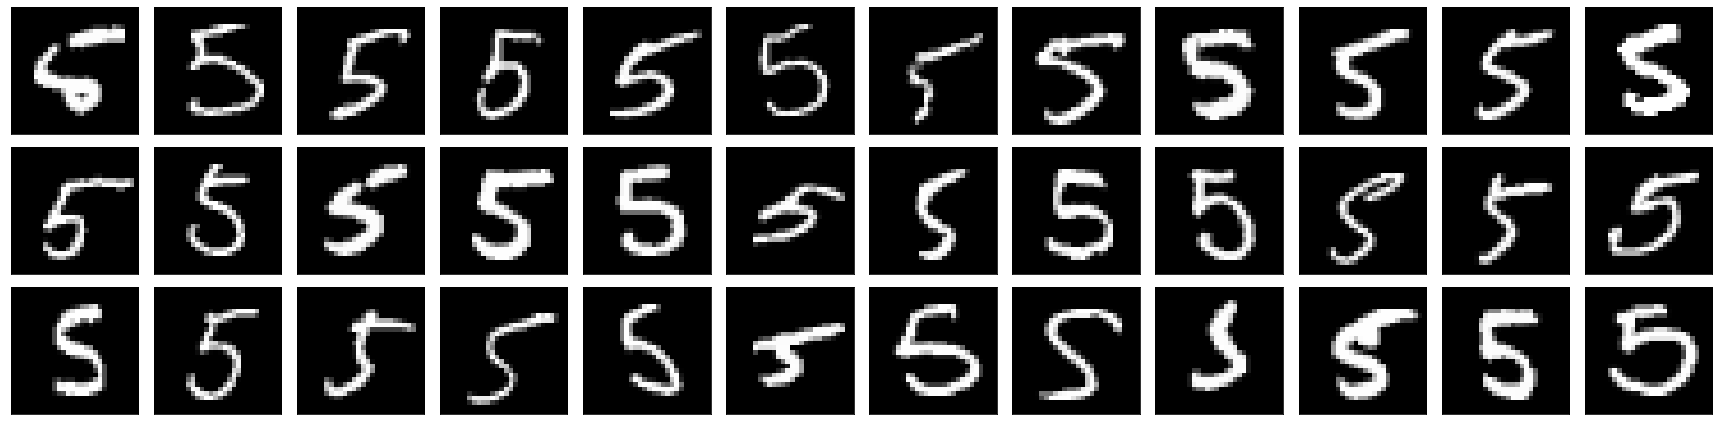

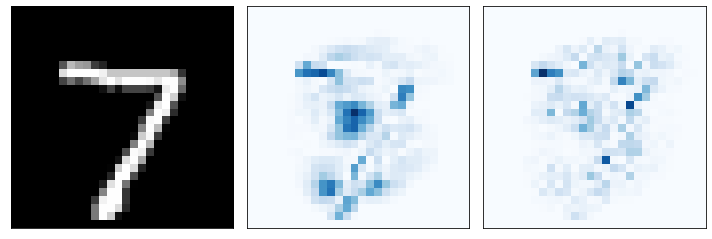

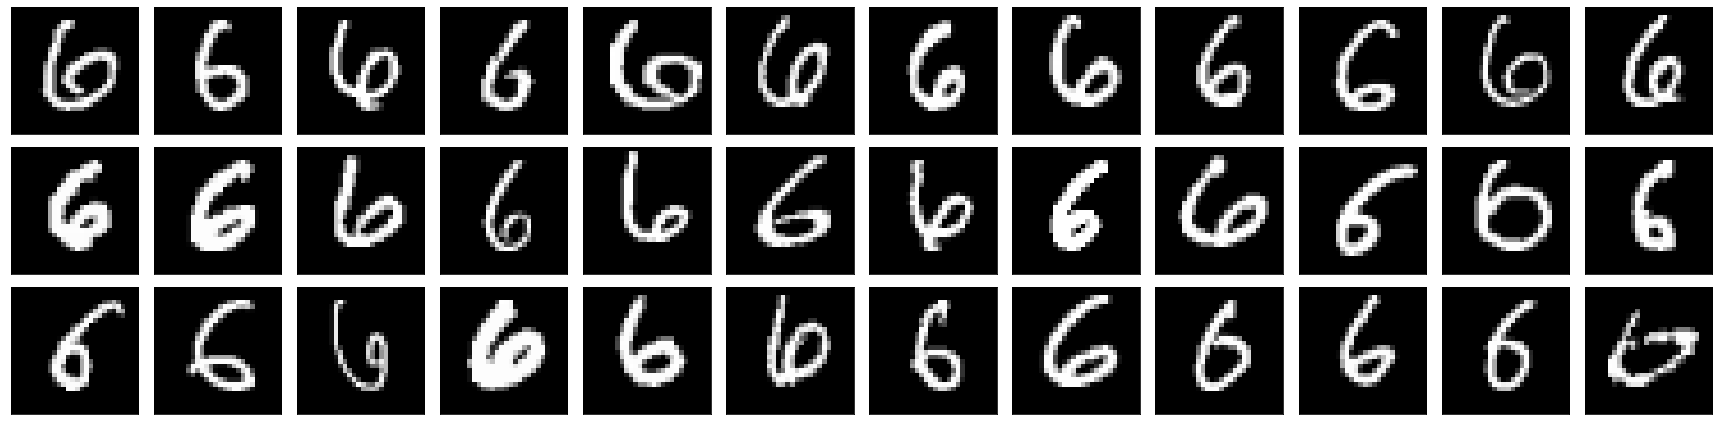

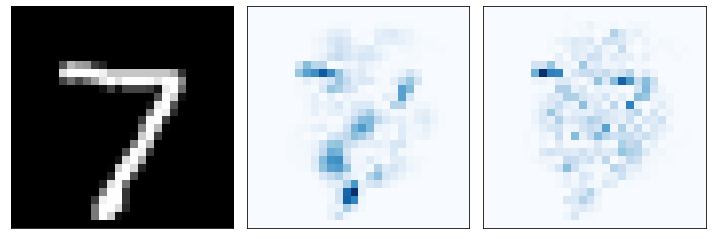

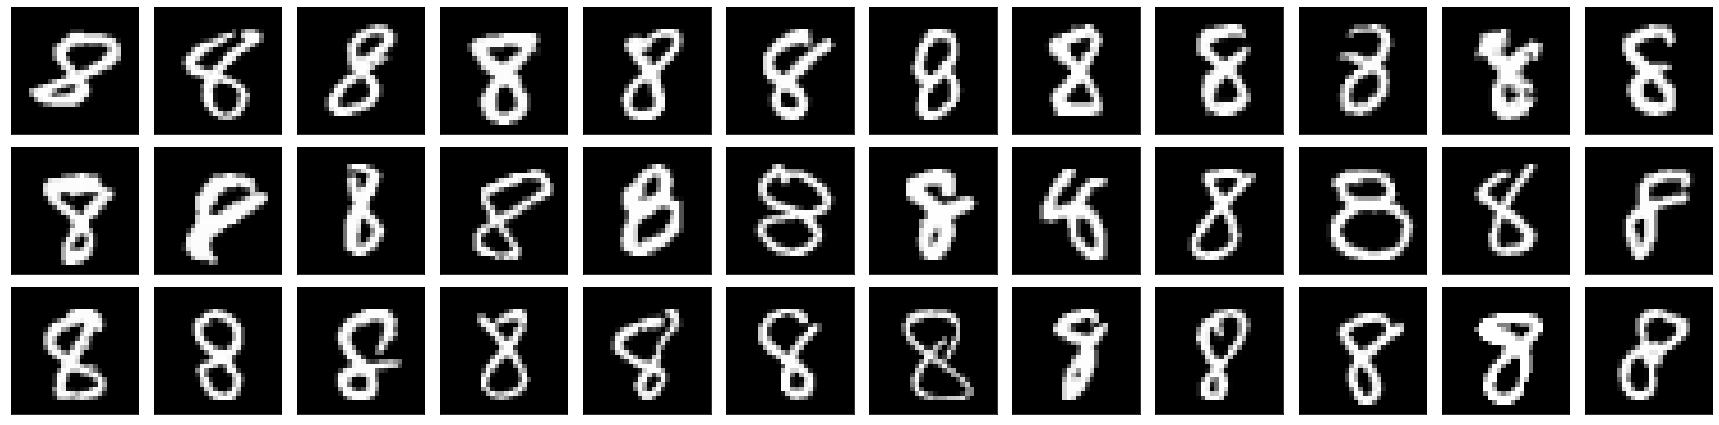

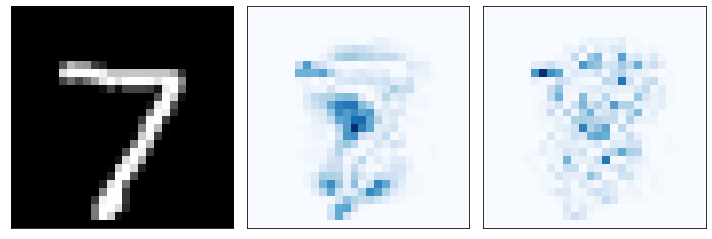

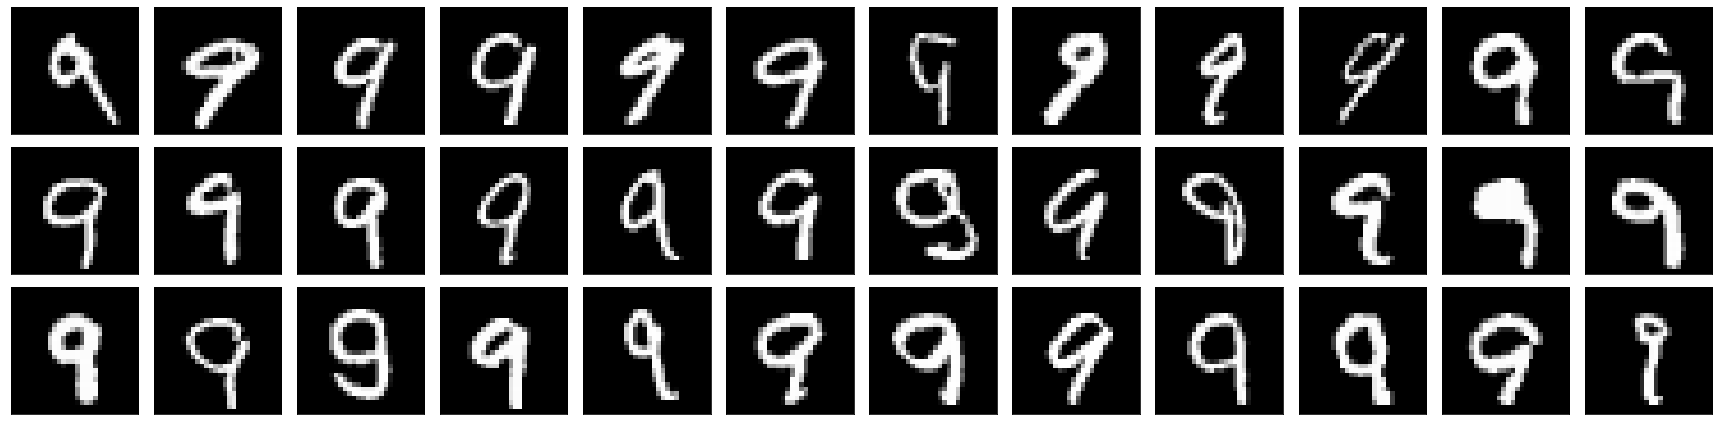

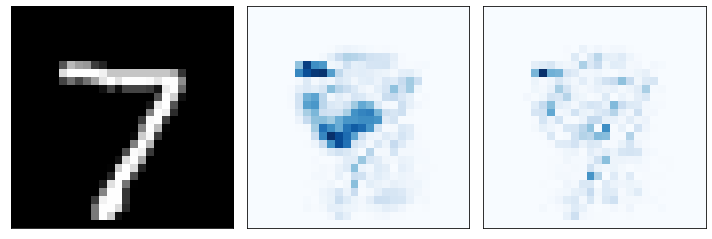

In [ ]:
# Mean IG with several baselines of the same class
def AIG_explainer(x_explain, baseline_class, model, model_rand, num_baselines = 16):
    # Get class
    class_specific_dataset = Class_MNIST(baseline_class, dataset_test)
    data_loader_class = DataLoader(class_specific_dataset,  batch_size = 1, shuffle = False, num_workers = 2)
    
    # Plot baselines
    num_col = int(np.sqrt(num_baselines)) * 2
    num_row = int(num_baselines / num_col)
    fig, axes = plt.subplots(num_row, num_col, figsize=(2* num_col,2*num_row))
    for i, (x_baseline, y) in enumerate(data_loader_class):
        if i >= num_baselines:
            break
        ax = axes[i // num_col, i % num_col]
        ax.imshow(x_baseline.numpy().squeeze(), cmap = "gray")
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()


    # AIG
    fig, axes = plt.subplots(1, 3, figsize = (10, 30))
    axes[0].imshow(x_explain.numpy().squeeze(), cmap = "gray")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Compute Average IG
    AIG = torch.zeros(28, 28)
    AIG_rand = torch.zeros(28, 28)
    for i, (x_baseline, y) in enumerate(data_loader_class):
        if i >= num_baselines:
            break
        # Normalize
        x_baseline = 2 * x_baseline - 1
        _, _, _, partial_attribution = IG_interp_saliency(x_explain, x_baseline, model)
        AIG += partial_attribution.sum(dim = 0).squeeze()
        _, _, _, partial_attribution = IG_interp_saliency(x_explain, x_baseline, model_rand)
        AIG_rand += partial_attribution.sum(dim = 0).squeeze()
    AIG /= num_baselines
    AIG_rand /= num_baselines

    # Clean Model
    axes[1].imshow(torch.abs(AIG), cmap = 'Blues')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Perturbed model
    axes[2].imshow(torch.abs(AIG_rand), cmap = 'Blues')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    
    plt.tight_layout()
    plt.show()

def AIG_tests():
    # Create a random model
    model_rand = CNN("smooth_CNN_mixup").to(device)

    for i in range(10):
        if not i == 7:
            AIG_explainer(x, i, model, model_rand, 36)

AIG_tests()

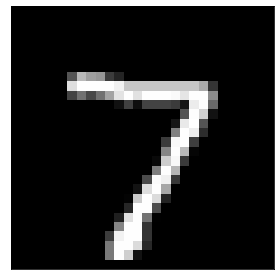

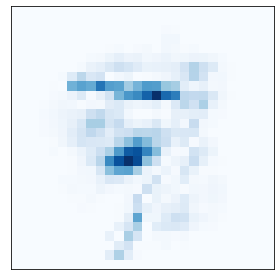

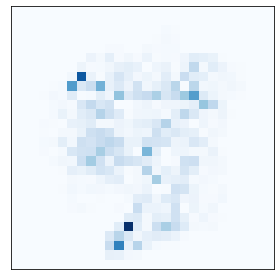